# Keras & Tensorflow multiclass classification
https://www.codesofinterest.com/2017/08/bottleneck-features-multi-class-classification-keras.html

In [18]:
import numpy as np  
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img  
from keras.models import Sequential  
from keras.layers import Dropout, Flatten, Dense  
from keras import applications  
from keras.utils.np_utils import to_categorical  
import matplotlib.pyplot as plt  
import math  
import cv2  

In [19]:
img_width, img_height = 224, 224  # image dimensions

top_model_weights_path = 'models/bottleneck_fc_model.h5'  # the top layer
train_data_dir = 'data/train/'
validation_data_dir = 'data/valid/'

epochs = 50
batch_size = 16

In [20]:
model = applications.VGG16(include_top=False, weights='imagenet')

In [21]:
def save_bottleneck_features():
    datagen = ImageDataGenerator(rescale=1. / 255)  

    generator = datagen.flow_from_directory(  
     train_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  

    nb_train_samples = len(generator.filenames)  
    num_classes = len(generator.class_indices)  

    predict_size_train = int(math.ceil(nb_train_samples / batch_size))  

    bottleneck_features_train = model.predict_generator(  
     generator, predict_size_train, verbose=1)  

    np.save('bottleneck_features_train.npy', bottleneck_features_train)  

    generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  

    nb_validation_samples = len(generator.filenames)  

    predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  

    bottleneck_features_validation = model.predict_generator(  
     generator, predict_size_validation, verbose=1)  

    np.save('bottleneck_features_validation.npy', bottleneck_features_validation)  
    
    # labels for training data
    datagen_top = ImageDataGenerator(rescale=1./255)  
    generator_top = datagen_top.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  

    nb_train_samples = len(generator_top.filenames)  
    num_classes = len(generator_top.class_indices)  

    # load the bottleneck features saved earlier  
    train_data = np.load('bottleneck_features_train.npy')  

    # get the class lebels for the training data, in the original order  
    train_labels = generator_top.classes  

    # convert the training labels to categorical vectors  
    train_labels = to_categorical(train_labels, num_classes=num_classes)  

    # labels for validation features
    generator_top = datagen_top.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  

    nb_validation_samples = len(generator_top.filenames)  

    validation_data = np.load('bottleneck_features_validation.npy')  

    validation_labels = generator_top.classes  
    validation_labels = to_categorical(validation_labels, num_classes=num_classes) 

# Create and train top model

In [22]:
def train_top_model():
    model = Sequential()  
    model.add(Flatten(input_shape=train_data.shape[1:]))  
    model.add(Dense(256, activation='relu'))  
    model.add(Dropout(0.5))  
    model.add(Dense(num_classes, activation='sigmoid'))  

    model.compile(optimizer='rmsprop',  
              loss='categorical_crossentropy', metrics=['accuracy'])  

    history = model.fit(train_data, train_labels,  
          epochs=epochs,  
          batch_size=batch_size,  
          validation_data=(validation_data, validation_labels))  

    model.save_weights(top_model_weights_path)  

    (eval_loss, eval_accuracy) = model.evaluate(  
     validation_data, validation_labels, batch_size=batch_size, verbose=1)

    print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
    print("[INFO] Loss: {}".format(eval_loss)) 

In [ ]:
save_bottleneck_features()

Found 56000 images belonging to 128 classes.
 279/3500 [=>............................] - ETA: 3:50:09

In [17]:
train_top_model()

NameError: name 'train_data' is not defined

# Plot stuff

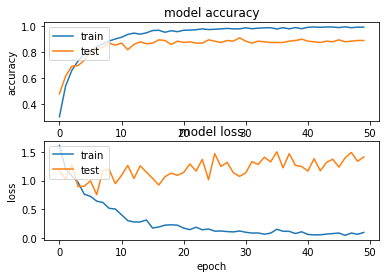

In [30]:
plt.figure(1)  

# summarize history for accuracy  
plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  

# summarize history for loss  
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show() 

# Prediction

In [6]:
# preprocess
image_path = 'data/test/2.jpg'  

orig = cv2.imread(image_path)  

print("[INFO] loading and preprocessing image...")  
image = load_img(image_path, target_size=(224, 224))  
image = img_to_array(image)  

# important! otherwise the predictions will be '0'  
image = image / 255  

image = np.expand_dims(image, axis=0)  

[INFO] loading and preprocessing image...


In [9]:
# run image through pipeline
# build the VGG16 network  
model = applications.VGG16(include_top=False, weights='imagenet')  

# get the bottleneck prediction from the pre-trained VGG16 model  
bottleneck_prediction = model.predict(image)  

# build top model  
model = Sequential()  
model.add(Flatten(input_shape=bottleneck_prediction.shape[1:]))  
model.add(Dense(256, activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(num_classes, activation='sigmoid'))  

model.load_weights(top_model_weights_path)  

# use the bottleneck prediction on the top model to get the final classification  
class_predicted = model.predict_classes(bottleneck_prediction) 

NameError: name 'num_classes' is not defined

In [10]:
inID = class_predicted[0]  

class_dictionary = generator_top.class_indices  

inv_map = {v: k for k, v in class_dictionary.items()}  

label = inv_map[inID]  

# get the prediction label  
print("Image ID: {}, Label: {}".format(inID, label))  

NameError: name 'class_predicted' is not defined